# REINFORCEMENT LEARNING PROJECT : 
# RINO AI 

In [1]:
# mss is used to capture the screen
from mss import mss
#used for sending commands
import pyautogui
# opencv for frame processing
import cv2
# transformational framework
import numpy as np
# ocr for "game over" extraction
import pytesseract
# visualize captured frames
from matplotlib import pyplot as plt
# for pauses 
# (between send commands and waiting
# for the frames to change)
import time
import os
import torch as th


# Environment components
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

In [2]:
print(os.environ['PATH'])
pytesseract.pytesseract.tesseract_cmd = '/home/enosim/anaconda3/envs/rl/bin/tesseract'


/home/enosim/anaconda3/envs/rl/bin:/home/enosim/anaconda3/condabin:/app/bin:/app/bin:/app/bin:/usr/bin:/home/enosim/.var/app/com.visualstudio.code/data/node_modules/bin


## MODEL 1

Rewards: (-1, +1)

$\epsilon$ scheduled to linearly decrease for 10% of training and then stay constant at 0.1.

$\gamma = 0.99$

$\alpha = 0.0001$


In [3]:
class WebGame(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(4, 84, 84), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = {'top':500, 'left':0, 'width':700, 'height':800}
        self.done_location = {'top':620, 'left':840, 'width':860, 'height':200}
        self.frame_delay = 0.005  # Delay between frames of a single observation (set to 5 ms)

    def get_observation(self):
        frames = []
        for _ in range(4):
            raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
            gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (84, 84))
            frames.append(resized)
            time.sleep(self.frame_delay)
        observation = np.stack(frames, axis=0) 
        # The axis=0 means that the frames are stacked along the first dimension of the array, 
        # which is the dimension that represents the number of frames. 
        # The result is an array of shape (4, 84, 84), which is the shape of the observation space.
        return observation

   
   
    def step(self, action):
         # Action key - 0 = Space, 1 = Duck (down), 2 = No action
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
            }
    
        if action != 2:
            pyautogui.press(action_map[action])  # Using pyautogui's press function
        
         # Checking whether the game is done
        done, done_cap = self.get_done()
    
         # Get the next observation
        new_observation = self.get_observation()
    
         # Reward - we get a point for every frame we are alive
        if done:
            reward = -1
        else:
            reward = 1

        info = {}
        truncated = False
        return new_observation, reward, done, truncated, info

    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        key = cv2.waitKey(10)
        if key & 0xFF == ord('q'):
            self.close()

    
     # Restart the game
    def reset(self, seed=None):
        time.sleep(1)
        info = {}
        pyautogui.click(x=250, y=250)
        pyautogui.press('space')
        return self.get_observation(), info
   
    
    def close(self):
        cv2.destroyAllWindows()

    # get the "game over" text using OCR
    def get_done(self):
        
     
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
     #   done_strings = ['GAME', 'G& A', 'GS A', 'GAHE']
        
        # Apply OCR
        done = False
        # character recognition
        res = pytesseract.image_to_string(done_cap)[:4]
        if res and res[0] == 'G':
            done = True
        
        return done, done_cap
    

## Exploring the environment

In [105]:
env = WebGame()


In [76]:
done, done_cap = env.get_done()
print(done)


True


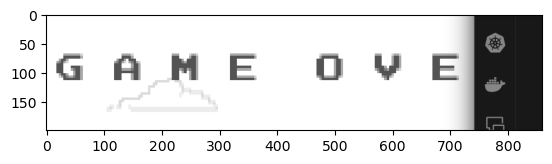

In [13]:
plt.imshow(done_cap)

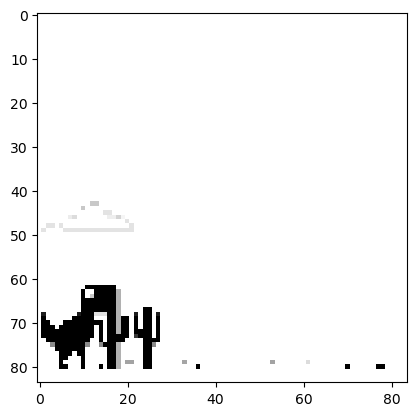

In [97]:
# Get a frame composing the observation
frame = env.get_observation()[0]
plt.imshow(frame, cmap='gray')  # Display the image in grayscale
plt.show()

### Create Callback 

In [4]:
# Import os for file path management
import os
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import CnnPolicy

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

2023-11-28 17:16:16.477269: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 17:16:16.478723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 17:16:16.503182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 17:16:16.503213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 17:16:16.503236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [6]:
# Check that the environment is okay
env_checker.check_env(env)


In [5]:
# the callback is used to save the model every n steps during training
# so that we can go back to the best model if the training is interrupted

class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        # check_freq is the number of steps between each save of the model in terms of learning steps
        # save_path is the path where the model will be saved, folder "train" in our case
        # verbose is the verbosity level: 0 no output, 1 info, 2 debug
   
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        # 'exist_ok=True' means that the directory will not be created if it already exists
   
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True
    # called after each training step
    # if the number of steps is a multiple of check_freq, the model is saved
    # the model is saved in the folder "train" with the name "best_model_{}" where {} is the number of steps
    

In [22]:
CHECKPOINT_DIR = "./train1"
LOG_DIR = './logs/'

In [23]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path = CHECKPOINT_DIR)

### Build DQN and train the model

In [8]:
# Import the DQN algorithm
from stable_baselines3 import DQN

In [24]:
# create the DQN model
model = DQN(CnnPolicy, env, tensorboard_log=LOG_DIR, verbose=1, 
            exploration_initial_eps=1.0,  # Initial value of epsilon
            exploration_final_eps=0.1,    # Final value of epsilon
            exploration_fraction=0.1,     # Fraction of entire training period over which the exploration rate is reduced
            buffer_size=100000, learning_starts=1000)

# The "buffer size" parameter specifies the number of experience tuples that the replay buffer can hold
# It's not measured in bytes or any other data size 
# but rather in the number of experiences (or transitions)
# Each entry in the replay buffer typically consists of
# a tuple of (state, action, reward, next state, done).
# Purpose: helps to avoid the correlation between consecutiive experiences
# and thus helps to stabilize and make the learning process more efficient (lowering variance).
# In the initial 1000 steps the agent's actions are random
# these initial steps allow the replay buffer to be filled with experiences
# before the actual learning begins
# Sampling refers to randomly selecting a batch of experiences from this buffer 
# to train the neural network. 
# Each training step doesn't just learn from the most recent experience 
# but rather from a diverse set of past experiences, which helps in generalizing 
# the learned policy.
# Older experiences are replaced by newer ones as the replay buffer fills up.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [27]:
model.learn(total_timesteps=90000, callback=callback)

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.2     |
|    ep_rew_mean      | 24.2     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 27       |
|    total_timesteps  | 105      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.6     |
|    ep_rew_mean      | 24.6     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 54       |
|    total_timesteps  | 213      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.5     |
|    ep_rew_mean      | 23.5     |
|    exploration_rate | 0.969    |
| time/               |        

### Functions for testing

In [9]:
# computes the average reward for a given model and a given number of episodes
def compute_average_rewards(start, stop, step, env, model_directory='train1', num_episodes=5):
    average_rewards = []
    iterations = range(start, stop + step, step)

    for iteration in iterations:
        model_path = os.path.join(model_directory, f'best_model_{iteration}')
        model = DQN.load(model_path)
        total_reward = 0

        for episode in range(num_episodes):
            obs, info = env.reset()
            done = False
            
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                action = int(action) if isinstance(action, np.ndarray) else action
                obs, reward, terminated, truncated, info = env.step(action)
                total_reward += reward
                done = terminated or truncated

        average_reward = total_reward / num_episodes
        average_rewards.append(average_reward)

    return average_rewards, iterations


In [10]:
def plot_average_rewards(average_rewards, iterations):
    plt.plot(iterations, average_rewards, marker='o')
    plt.xlabel('#Training Iterations')
    plt.ylabel('Average Cumulative Reward')
    plt.title('Rewards as performance metrics', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
    plt.xticks(range(10000, 100000, 10000)) 
    plt.grid()
    plt.show()


In [11]:
env = WebGame()

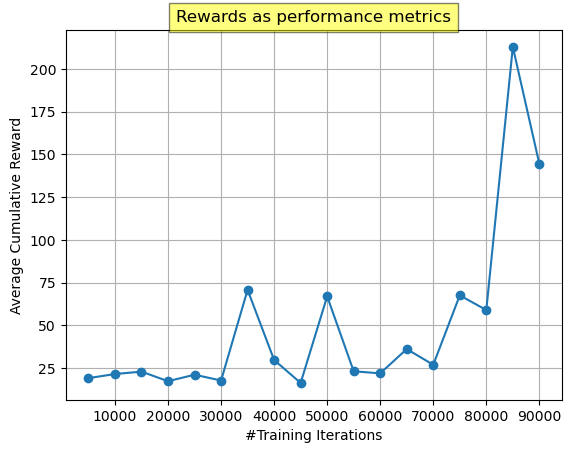

In [28]:
# Plot the average rewards
avg_rewards, iterations = compute_average_rewards(5000, 90000, 5000, env, model_directory='train1')
plot_average_rewards(avg_rewards, iterations)

In [12]:
def collect_states(env, num_states):
    states = []
    for _ in range(num_states):
        obs, info = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()  # Random action
            obs, _, done, _, _ = env.step(action)
            if not done:
                states.append(obs)
    return np.array(states)


In [13]:

def evaluate_average_max_q(model, fixed_states):
    max_q_values = []
    for state in fixed_states:
        obs_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to(model.device)
        
        # Use the Q-network of the policy to get Q-values
        q_values = model.policy.q_net(obs_tensor)

        
        q_values_np = q_values.cpu().detach().numpy()
        
        max_q_values.append(np.max(q_values_np)) # Take the maximum Q-value

    average_max_q = np.mean(max_q_values)
    return average_max_q

In [14]:

def calculate_average_max_q_for_models(env, start, stop, step, num_states, directory='train1'):
    states = collect_states(env, num_states)
    average_max_qs = []
    iterations = range(start, stop + step, step)

    for model_num in iterations:
        model_path = os.path.join(directory, f'best_model_{model_num}')
        model = DQN.load(model_path)
        average_max_q = evaluate_average_max_q(model, states)
        average_max_qs.append(average_max_q)
            
    return average_max_qs, iterations


In [15]:
def plot_q_values(average_max_qs, iterations):
    plt.plot(iterations, average_max_qs, marker='o')
    plt.xlabel('#Training Iterations')
    plt.ylabel('Average Max Q Value')
    plt.title('Max Q Values as performance metrics', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
    plt.grid()
    plt.show()

### Testing Model 1

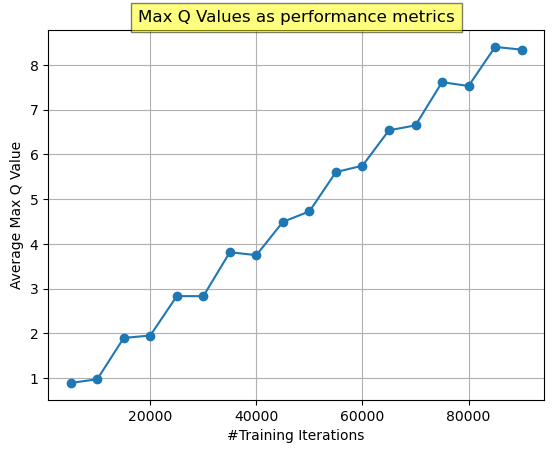

In [39]:
num_states_to_sample = 20

average_max_qs, iterations = calculate_average_max_q_for_models(env, 5000, 90000, 5000, num_states_to_sample, directory='train1')

plot_q_values(average_max_qs, iterations)    

In [13]:
# To visualize the CNN layers
print(model.policy.q_net)

QNetwork(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (q_net): Sequential(
    (0): Linear(in_features=512, out_features=3, bias=True)
  )
)


## MODEL 2

Rewards: (-1, +0.05)

$\epsilon$ scheduled to linearly decrease for 10% of training and then stay constant at 0.1.

$\gamma = 0.99$

$\alpha = 0.0001$


In [41]:
class WebGame2(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(4, 84, 84), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = {'top':500, 'left':0, 'width':800, 'height':700}
        self.done_location = {'top':620, 'left':840, 'width':860, 'height':200}
        self.frame_delay = 0.005  # Delay between frames of a single observation (set to 5 ms)

    def get_observation(self):
        frames = []
        for _ in range(4):
            raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
            gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (84, 84))
            frames.append(resized)
            time.sleep(self.frame_delay)
        observation = np.stack(frames, axis=0) 
        # The axis=0 means that the frames are stacked along the first dimension of the array, 
        # which is the dimension that represents the number of frames. 
        # The result is an array of shape (4, 84, 84), which is the shape of the observation space.
        return observation

   
   
    def step(self, action):
         # Action key - 0 = Space, 1 = Duck (down), 2 = No action
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
            }
    
        if action != 2:
            pyautogui.press(action_map[action])  # Using pyautogui's press function
        
         # Checking whether the game is done
        done, done_cap = self.get_done()
    
         # Get the next observation
        new_observation = self.get_observation()
    
         # Reward - we get a point for every frame we are alive
        if done:
            reward = -1
        else:
            reward = 0.05

        info = {}
        truncated = False
        return new_observation, reward, done, truncated, info

    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        key = cv2.waitKey(10)
        if key & 0xFF == ord('q'):
            self.close()

    
     # Restart the game
    def reset(self, seed=None):
        time.sleep(1)
        info = {}
        pyautogui.click(x=250, y=250)
        pyautogui.press('space')
        return self.get_observation(), info
   
    
    def close(self):
        cv2.destroyAllWindows()

    # get the "game over" text using OCR
    def get_done(self):
        
     
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
    
        
        # Apply OCR
        done = False
        # character recognition
        res = pytesseract.image_to_string(done_cap)[:4]
        if res and res[0] == 'G':
            done = True
        
        return done, done_cap
    

In [109]:
env2 = WebGame2()
model2 = DQN(CnnPolicy, env2, tensorboard_log=LOG_DIR, verbose=1, 
            exploration_initial_eps=1.0,  # Initial value of epsilon
            exploration_final_eps=0.1,    # Final value of epsilon
            exploration_fraction=0.1,     # Fraction of entire training period over which the exploration rate is reduced
            buffer_size=100000, learning_starts=1000)
LOG_DIR = './logs/'
CHECKPOINT_DIR = "./train2"
callback2 = TrainAndLoggingCallback(check_freq=5000, save_path = CHECKPOINT_DIR)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model2.learn(total_timesteps=90000, callback=callback2)

Logging to ./logs2/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.8     |
|    ep_rew_mean      | 0.138    |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 26       |
|    total_timesteps  | 95       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.1     |
|    ep_rew_mean      | 0.106    |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 50       |
|    total_timesteps  | 185      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25       |
|    ep_rew_mean      | 0.2      |
|    exploration_rate | 0.97     |
| time/               |       

In [36]:
# Compute the average rewards
avg_rewards2, iterations2 = compute_average_rewards(5000, 90000, 5000, env2, model_directory='train2')




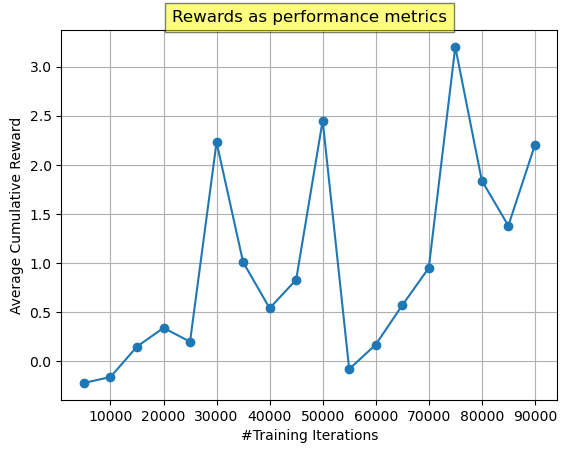

In [18]:
# Plot the average rewards
plot_average_rewards(avg_rewards2, iterations2)

In [22]:
num_states_to_sample = 20

# Calculate the metric for models trained for 10,000 to 90,000 iterations
average_max_qs3, iterations3 = calculate_average_max_q_for_models(env2, 5000, 90000, 5000, num_states_to_sample, directory='train2')



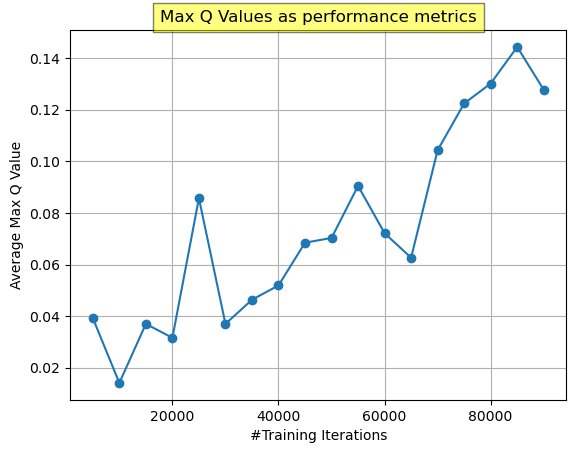

In [24]:
plot_q_values(average_max_qs3, iterations3)

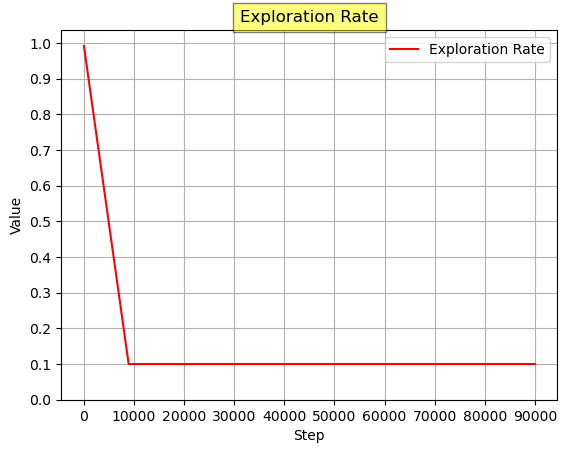

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

epsilon = pd.read_csv('~/Desktop/exp_rate.csv') 
plt.plot(epsilon['Step'], epsilon['Value'], label='Exploration Rate', color='red')
plt.title('Exploration Rate',  bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
plt.xlabel('Step')
plt.ylabel('Value')
plt.xticks(np.arange(0, 100000, 10000))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid()
plt.show()


## COMPARING THE MODELS USING AVERAGE EPISODE DURATION
This is a highly unreliable and variable measure, also because averages are computed only over only 5 episodes. In spite of this the superior performance of model 1 with respect to model 2 is very clear from the plot.

In [31]:
# Useful to compare the performance of models with different reward structures

def calculate_average_duration(model_directory, start, step, stop, env, num_episodes=100):
    durations = []
    iterations = range(start, stop + step, step)

    for iteration in iterations:
        model_path = os.path.join(model_directory, f'best_model_{iteration}')
        model = DQN.load(model_path)

        for episode in range(num_episodes):
            obs, info = env.reset()
            done = False
            total = 0
            time = 0
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                action = int(action) if isinstance(action, np.ndarray) else action
                obs, reward, terminated, truncated, info = env.step(action)
                time += 1
                done = terminated or truncated
            total += time
            average_duration = total / num_episodes
        durations.append(average_duration)
        
    return durations, iterations

In [43]:
def plot_durations(durations1, durations2,  iterations):
    plt.plot(iterations, durations1, marker='o', color='blue', label='Model 1')
    plt.plot(iterations, durations2, marker='o', color='green', label='Model 2')
    plt.xlabel('Training Iterations')
    plt.ylabel('Average Episode Duration')
    plt.title('Average Episode Duration', bbox=dict(facecolor='yellow', alpha=0.5))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


In [45]:
dur = calculate_average_duration('train1', 5000, 5000, 90000, env, num_episodes=5)

dur2 = calculate_average_duration('train2', 5000, 5000, 90000, env2, num_episodes=5)

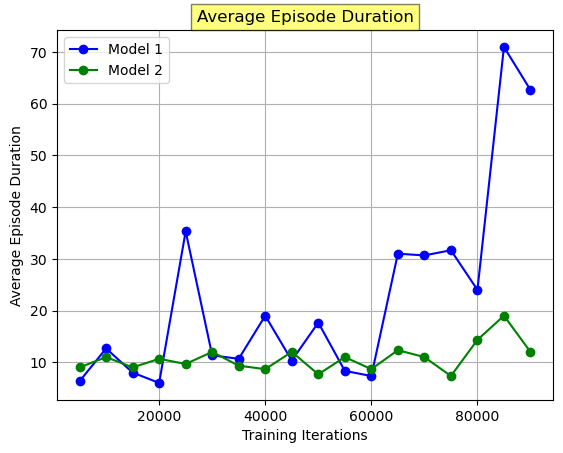

In [49]:
plot_durations(dur[0], dur2[0],  dur[1])